In [1]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import fiona
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from geofeather import to_geofeather, from_geofeather

In [2]:
# Source data, TanDEM-X
tdx_hgt_source = os.path.join('/Users/arbailey/natcap/idb/data/source/nasa/TDXCHMAGBAndros','Andros_TDX_DEM_12m_EGM2008_CHM_Cal_mask.tif')
# Working Directory
work_dir = '/Users/arbailey/natcap/idb/data/work/andros_mangrovehgt'
os.chdir(work_dir)

In [3]:
# Import the previously joined point file layer (with SRTM & mangrove extents) into GeoDataFrame 
%time gliht_srtm_hmax95_mangroves4 = from_geofeather('gliht_srtm_hmax95_mangroves4.feather')
gliht_srtm_hmax95_mangroves4

CPU times: user 10min 7s, sys: 46.3 s, total: 10min 54s
Wall time: 11min 2s


,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m
0,0.0,788785.5,2787858.5,0,21282071,NaN,14210037,1,NaN,NaN,NaN,NaN,POINT (-78.13478 25.17915),1.586909
1,0.0,788781.5,2787857.5,0,21282071,NaN,14210036,2,NaN,NaN,NaN,NaN,POINT (-78.13482 25.17914),1.534521
2,0.0,788784.5,2787857.5,0,21282071,NaN,14210037,3,NaN,NaN,NaN,NaN,POINT (-78.13479 25.17914),1.539167
3,0.0,788776.5,2787856.5,0,21282070,NaN,14210036,4,NaN,NaN,NaN,NaN,POINT (-78.13487 25.17913),1.515844
4,0.0,788778.5,2787856.5,0,21282071,NaN,14210036,5,NaN,NaN,NaN,NaN,POINT (-78.13485 25.17913),1.567966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58150139,0.0,802646.5,2691223.5,0,43944037,NaN,44267460,58146867,NaN,NaN,NaN,NaN,POINT (-78.01828 24.30487),1.282259
58150140,0.0,802641.5,2691222.5,0,43951238,NaN,44267460,58146868,NaN,NaN,NaN,NaN,POINT (-78.01833 24.30486),1.335587
58150141,0.0,802644.5,2691221.5,0,43951238,NaN,44267460,58146869,NaN,NaN,NaN,NaN,POINT (-78.01830 24.30485),1.293845
58150142,0.0,802646.5,2691220.5,0,43951238,NaN,44267460,58146870,NaN,NaN,NaN,NaN,POINT (-78.01828 24.30484),1.329463


In [4]:
# Create Variable for master points data 
pts_all = gliht_srtm_hmax95_mangroves4

In [5]:
# TanDEM-X height raster
tdxhgt = rio.open(tdx_hgt_source) # as rasterio dataset
tdxhgt_np = tdxhgt.read(1, masked=True)  # Read to 2D masked NumPy Array

In [6]:
def range2datatype(data_np):
    """
    Calculate the rasterio minimum data type that will hold the range of values in the array
    :param data_np: NumPy array of data values
    :return: datatype:  minimum datatype to include the range of values in the array
    """
    min_value = np.min(data_np)
    max_value = np.max(data_np)
    datatype = rio.dtypes.get_minimum_dtype([min_value, max_value])
    return datatype

In [7]:
def create_raster(data_np, metadata, out_file):
    """
    Create a single band raster file from a NumPy array with the specified metadata and output filename/path
    :param data_np: Input NumPy data array
    :param metadata: Spatial metadata for output raster
    :param out_file: output raster filename or full path
    :return:
    """
    # Check datatypes of array and metadata - change array to match metadata if necessary
    if data_np.dtype != metadata['dtype']:
        data_np = data_np.astype(metadata['dtype'])

    # Create output raster
    with rio.open(out_file, 'w', **metadata) as dst:
        dst.write(data_np, 1)
    print(out_file)

In [8]:
def create_uniqueid_raster(in_raster_source, out_raster_source):
    # Create an array with unique ID for each input raster pixel
    with rio.open(in_raster_source) as src:
        rows, cols = src.shape
        uniqueid_np = np.arange(rows * cols).reshape(rows, cols) + 1 # want to start at 1 and not zero for ids
        uniqueid_meta = src.meta
    print(uniqueid_np.dtype)
    uniqueid_dtype = range2datatype(uniqueid_np)
    print(uniqueid_dtype)
    uniqueid_meta['dtype'] = uniqueid_dtype # change data type to integer
    
    # Create output raster
    create_raster(uniqueid_np, uniqueid_meta, out_raster_source)

In [9]:
# Create a raster of unique IDs corresponding to TanDEM-X height raster
tdxhgt_uniqueid_source = 'Andros_TDX_DEM_12m_EGM2008_CHM_Cal_mask_uniqueid.tif'
create_uniqueid_raster(tdx_hgt_source, tdxhgt_uniqueid_source)
tdxhgt_uniqueid = rio.open(tdxhgt_uniqueid_source, 'r')

int64
uint32
Andros_TDX_DEM_12m_EGM2008_CHM_Cal_mask_uniqueid.tif


In [10]:
def point_coords(geom):
    # Return a tuple with the x/y point coordinate for a GeoDataFrame geometry
    # return list(geom.coords)
    return list(geom.coords)[0] # Just get first tuple in list, since it's a point
# Get Lat/Long coordinates from GDF's geometry
pts_all_ll = pts_all.apply(lambda row: point_coords(row.geometry), axis=1)

In [11]:
pts_all_ll

0           (-78.13477705237545, 25.179147458447183)
1           (-78.13481691073252, 25.179139207145507)
2             (-78.1347871752592, 25.17913863097257)
3           (-78.13486668090961, 25.179131147886178)
4            (-78.13484685726108, 25.17913076377834)
                              ...                   
58150139    (-78.01827669463025, 24.304867119970613)
58150140    (-78.01832611423994, 24.304859067190282)
58150141    (-78.01829680007057, 24.304849467431392)
58150142    (-78.01827732762668, 24.304840061041524)
58150143    (-78.01823838274811, 24.304821248255095)
Length: 58150144, dtype: object

In [12]:
def cellval2point(raster, ptcoords, gdf, attribute):
    # Samples the raster value at each point, 
    # then attaches it to original data frame with new attribute name
    sample_gen = raster.sample(xy=ptcoords)
    sample = list(sample_gen)
    gdf[attribute] = np.vstack(sample)
    
# Sample unique ID raster with point coords    
%time cellval2point(tdxhgt_uniqueid, pts_all_ll, pts_all, 'tdx_id')

# Sample TanDEM-X height raster with point coords
%time cellval2point(tdxhgt, pts_all_ll, pts_all, 'tdxmanght_m')

print(pts_all.head())
print(pts_all.describe())

CPU times: user 53min 24s, sys: 1min 7s, total: 54min 31s
Wall time: 55min 19s
CPU times: user 59min 3s, sys: 1min 22s, total: 1h 26s
Wall time: 1h 1min 21s
   z_m  x_utm17n   y_utm17n  srtm_m   srtm_id  hmax95  hmax95_id  gliht_ptid  \
0  0.0  788785.5  2787858.5       0  21282071     NaN   14210037           1   
1  0.0  788781.5  2787857.5       0  21282071     NaN   14210036           2   
2  0.0  788784.5  2787857.5       0  21282071     NaN   14210037           3   
3  0.0  788776.5  2787856.5       0  21282070     NaN   14210036           4   
4  0.0  788778.5  2787856.5       0  21282071     NaN   14210036           5   

   gmf  wam  gmw2015  tnclandsat                    geometry   dtm_z_m  \
0  NaN  NaN      NaN         NaN  POINT (-78.13478 25.17915)  1.586909   
1  NaN  NaN      NaN         NaN  POINT (-78.13482 25.17914)  1.534521   
2  NaN  NaN      NaN         NaN  POINT (-78.13479 25.17914)  1.539167   
3  NaN  NaN      NaN         NaN  POINT (-78.13487 25.17913)  1.51

In [13]:
%time to_geofeather(pts_all, 'andros_gliht_srtm_hmax95_tdx_mangroves2.feather')

CPU times: user 11min 48s, sys: 1min 15s, total: 13min 4s
Wall time: 14min 2s


In [14]:
# Functions for geodataframe subsetting and grouping

# Subset points Geodataframe based on GLiHT Canopy Height > 0 and specified mangrove presence attribute
def subset_mangrove(pts_gdf, mangrove_attribute):
    subset_gdf = pts_gdf[(pts_gdf['z_m'] > 0) & (pts_gdf[mangrove_attribute] > 0) & (pts_gdf['tdxmanght_m'] > 0)]
    return subset_gdf

# GRoup Data frame with some summary stats on GLiHT canopy heights
def grouped_glihtCHM(pts_gdf, grouping_cols=['srtm_id','srtm_m']):
    grouped_df = pts_gdf.groupby(
        grouping_cols
    ).agg(
        max_z = ('z_m', 'max'),
        min_z = ('z_m', 'min'),
        mean_z = ('z_m', 'mean'),
        median_z = ('z_m', 'median'),
        var_z = ('z_m', 'var'),
        skew_z = ('z_m', 'skew'),
        count_z = ('z_m', 'count'),
    ) 
    grouped_df.reset_index(inplace=True)  # Reset index to make grouped columns into regular columns   
    return grouped_df

In [15]:
pts_gt0_gmf = subset_mangrove(pts_all, 'gmf')
pts_gt0_gmf

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m,tdx_id,tdxmanght_m
40956198,0.54,802959.5,2715709.5,7,38226473,NaN,36677638,40956199,1.0,NaN,NaN,1.0,POINT (-78.00999 24.52566),1.738985,238864180,0.666772
40956199,0.31,802971.5,2715709.5,7,38226473,NaN,36677638,40956200,1.0,NaN,NaN,1.0,POINT (-78.00987 24.52565),1.695375,238864181,0.327052
40958790,0.70,802963.5,2715706.5,7,38226473,NaN,36677638,40958791,1.0,NaN,NaN,1.0,POINT (-78.00995 24.52563),1.869483,238864180,0.666772
40961393,0.60,802973.5,2715703.5,6,38226474,NaN,36677638,40961394,1.0,NaN,NaN,1.0,POINT (-78.00986 24.52560),1.973770,238882182,0.373069
40964002,1.28,802959.5,2715700.5,7,38226473,NaN,36677638,40964003,1.0,NaN,NaN,1.0,POINT (-78.01000 24.52558),2.042457,238882181,0.059496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57670715,0.48,803953.5,2694143.5,2,43274393,NaN,43374588,57667443,1.0,NaN,NaN,1.0,POINT (-78.00479 24.33095),1.763109,270401979,0.510333
57670719,0.98,803957.5,2694143.5,2,43274393,NaN,43374588,57667447,1.0,NaN,NaN,1.0,POINT (-78.00476 24.33095),1.684775,270401979,0.510333
57670727,0.10,803965.5,2694143.5,2,43274393,NaN,43374588,57667455,1.0,NaN,NaN,1.0,POINT (-78.00468 24.33095),1.748793,270401980,0.655496
57671066,1.29,803895.5,2694142.5,4,43274391,NaN,43374585,57667794,1.0,NaN,NaN,1.0,POINT (-78.00537 24.33095),1.277882,270401974,0.207820


In [16]:
pts_gt0_gmw2015 = subset_mangrove(pts_all, 'gmw2015')
pts_gt0_gmw2015

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m,tdx_id,tdxmanght_m
528814,1.14,790619.5,2784542.5,3,22067043,NaN,15247049,528815,NaN,NaN,1.0,1.0,POINT (-78.11730 25.14889),2.003727,137895605,0.790738
528815,0.94,790620.5,2784542.5,3,22067043,NaN,15247049,528816,NaN,NaN,1.0,1.0,POINT (-78.11729 25.14889),1.939394,137895605,0.790738
528816,0.71,790621.5,2784542.5,3,22067043,NaN,15247049,528817,NaN,NaN,1.0,1.0,POINT (-78.11728 25.14889),2.017261,137895605,0.790738
528817,0.66,790622.5,2784542.5,3,22067043,NaN,15247049,528818,NaN,NaN,1.0,1.0,POINT (-78.11727 25.14889),2.070619,137895606,1.047505
528818,1.03,790623.5,2784542.5,3,22067043,NaN,15247049,528819,NaN,NaN,1.0,1.0,POINT (-78.11726 25.14888),2.119029,137895606,1.047505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57993114,0.65,803085.5,2691928.5,-6,43785631,NaN,44051447,57989842,NaN,NaN,1.0,1.0,POINT (-78.01381 24.31114),1.338612,273624077,0.627966
57999722,0.83,803058.5,2691911.5,4,43785630,NaN,44058647,57996450,NaN,NaN,1.0,1.0,POINT (-78.01408 24.31099),1.226459,273642075,0.305240
57999723,1.58,803059.5,2691911.5,4,43785630,NaN,44058647,57996451,NaN,NaN,1.0,1.0,POINT (-78.01407 24.31099),1.210000,273642075,0.305240
58000111,1.25,803057.5,2691910.5,4,43785630,NaN,44058647,57996839,NaN,NaN,1.0,1.0,POINT (-78.01409 24.31098),1.236979,273642075,0.305240


In [17]:
pts_gt0_wam = subset_mangrove(pts_all, 'wam')
pts_gt0_wam

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m,tdx_id,tdxmanght_m
1148154,1.44,791859.5,2782602.5,1,22527949,NaN,15859179,1148155,NaN,1.0,1.0,NaN,POINT (-78.10543 25.13115),2.209809,140775872,1.343643
1148157,0.38,791862.5,2782602.5,0,22527950,NaN,15859179,1148158,NaN,1.0,1.0,NaN,POINT (-78.10540 25.13115),2.259695,140775872,1.343643
1148554,1.69,791859.5,2782601.5,1,22527949,NaN,15859179,1148555,NaN,1.0,1.0,NaN,POINT (-78.10543 25.13114),2.445219,140775872,1.343643
1148555,0.29,791860.5,2782601.5,1,22527949,NaN,15859179,1148556,NaN,1.0,1.0,NaN,POINT (-78.10542 25.13114),2.311780,140775872,1.343643
1148556,0.31,791861.5,2782601.5,0,22527950,NaN,15859179,1148557,NaN,1.0,1.0,NaN,POINT (-78.10541 25.13114),2.439429,140775872,1.343643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57099968,0.39,796589.5,2695940.5,5,42813269,NaN,42762225,57099969,NaN,1.0,NaN,1.0,POINT (-78.07691 24.34857),1.387467,267557172,0.435454
57100201,0.24,796618.5,2695939.5,3,42813270,NaN,42762226,57100202,NaN,1.0,NaN,1.0,POINT (-78.07663 24.34856),1.367879,267557174,0.352724
57100671,0.64,796894.5,2695937.5,5,42813280,NaN,42769438,57100672,NaN,1.0,NaN,1.0,POINT (-78.07391 24.34849),1.359842,267575200,0.212658
57101319,0.63,796760.5,2695934.5,5,42813275,NaN,42769432,57101320,NaN,1.0,NaN,1.0,POINT (-78.07523 24.34849),1.390985,267575188,0.210747


In [18]:
pts_gt0_tnclandsat = subset_mangrove(pts_all, 'tnclandsat') 
pts_gt0_tnclandsat

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m,tdx_id,tdxmanght_m
378639,0.56,790135.5,2785233.5,0,21901403,NaN,15031001,378640,NaN,NaN,NaN,1.0,POINT (-78.12195 25.15521),1.779235,136869506,0.862588
381211,4.61,790136.5,2785222.5,0,21908604,NaN,15038202,381212,NaN,NaN,NaN,1.0,POINT (-78.12194 25.15511),1.757707,136887507,0.048023
381457,3.95,790136.5,2785221.5,0,21908604,NaN,15038202,381458,NaN,NaN,NaN,1.0,POINT (-78.12195 25.15510),1.693191,136887507,0.048023
392775,0.94,790528.5,2785177.5,1,21915819,NaN,15045418,392776,NaN,NaN,NaN,1.0,POINT (-78.11807 25.15463),1.852557,136959546,0.563094
398823,0.31,790528.5,2785148.5,0,21923020,NaN,15059820,398824,NaN,NaN,NaN,1.0,POINT (-78.11808 25.15437),1.777743,137013549,0.012285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58091128,0.40,802808.5,2691685.5,0,43843229,NaN,44123446,58087856,NaN,NaN,NaN,1.0,POINT (-78.01658 24.30900),1.217595,273966071,1.214203
58091133,1.07,802813.5,2691685.5,0,43843229,NaN,44123446,58087861,NaN,NaN,NaN,1.0,POINT (-78.01654 24.30900),1.218794,273966071,1.214203
58091134,0.55,802814.5,2691685.5,0,43843230,NaN,44123446,58087862,NaN,NaN,NaN,1.0,POINT (-78.01653 24.30900),1.214953,273966071,1.214203
58091137,0.28,802817.5,2691685.5,0,43843230,NaN,44123446,58087865,NaN,NaN,NaN,1.0,POINT (-78.01650 24.30900),1.234743,273966072,2.170952


In [19]:
groupedTDX_gliht_gmf = grouped_glihtCHM(pts_gt0_gmf, ['tdx_id', 'tdxmanght_m'])
groupedTDX_gliht_gmf

,tdx_id,tdxmanght_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,238864180,0.666772,0.70,0.54,0.620000,0.620,0.012800,NaN,2
1,238864181,0.327052,0.31,0.31,0.310000,0.310,NaN,NaN,1
2,238882180,0.257963,0.56,0.25,0.405000,0.405,0.048050,NaN,2
3,238882181,0.059496,1.28,0.19,0.530000,0.310,0.196650,1.711601,5
4,238882182,0.373069,0.95,0.60,0.752500,0.730,0.032358,0.212215,4
...,...,...,...,...,...,...,...,...,...
13464,270401975,0.045569,1.37,0.94,1.076667,0.995,0.029627,1.269520,6
13465,270401977,0.192177,1.79,0.20,0.842174,0.860,0.189472,0.486191,23
13466,270401978,0.395025,2.30,0.07,1.017037,0.845,0.420889,0.461076,54
13467,270401979,0.510333,2.33,0.14,1.151509,1.110,0.435109,0.353515,53


In [20]:
groupedTDX_gliht_gmw2015 = grouped_glihtCHM(pts_gt0_gmw2015, ['tdx_id', 'tdxmanght_m'])
groupedTDX_gliht_gmw2015

,tdx_id,tdxmanght_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,137895605,0.790738,1.40,0.58,0.937500,0.850,0.099279,0.465067,8
1,137895606,1.047505,2.91,0.52,1.286545,1.170,0.317912,1.192960,55
2,137895607,1.105602,2.07,0.38,1.145833,1.135,0.182174,0.200455,36
3,137913607,0.129635,2.07,0.34,1.086316,1.000,0.226280,0.529700,19
4,137913608,0.991897,5.27,0.57,1.568235,1.420,0.726847,2.621536,51
...,...,...,...,...,...,...,...,...,...
16854,270365968,0.059362,2.78,0.93,1.620000,1.100,0.688650,0.832205,5
16855,270383966,0.224124,0.93,0.93,0.930000,0.930,NaN,NaN,1
16856,273570075,0.664495,0.59,0.59,0.590000,0.590,NaN,NaN,1
16857,273624077,0.627966,0.65,0.65,0.650000,0.650,NaN,NaN,1


In [21]:
groupedTDX_gliht_wam = grouped_glihtCHM(pts_gt0_wam, ['tdx_id', 'tdxmanght_m'])
groupedTDX_gliht_wam

,tdx_id,tdxmanght_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,140775872,1.343643,2.47,0.15,1.020189,1.010,0.280390,0.598497,53
1,140775873,1.515478,3.02,0.06,1.073684,0.920,0.581888,1.066686,57
2,140775874,0.725350,1.44,0.12,0.669231,0.580,0.242141,0.504623,13
3,140793872,0.920946,2.05,0.41,1.153077,1.095,0.257854,0.188730,26
4,140793873,1.680841,2.81,0.21,1.249400,1.280,0.376824,0.319492,100
...,...,...,...,...,...,...,...,...,...
2855,267557187,0.604061,0.30,0.30,0.300000,0.300,NaN,NaN,1
2856,267557203,0.047938,0.30,0.17,0.235000,0.235,0.008450,NaN,2
2857,267575188,0.210747,0.63,0.63,0.630000,0.630,NaN,NaN,1
2858,267575200,0.212658,0.64,0.64,0.640000,0.640,NaN,NaN,1


In [22]:
groupedTDX_gliht_tnclandsat = grouped_glihtCHM(pts_gt0_tnclandsat, ['tdx_id', 'tdxmanght_m'])
groupedTDX_gliht_tnclandsat

,tdx_id,tdxmanght_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,136869506,0.862588,0.56,0.56,0.560000,0.560,NaN,NaN,1
1,136887507,0.048023,4.61,3.95,4.280000,4.280,0.217800,NaN,2
2,136959546,0.563094,0.94,0.94,0.940000,0.940,NaN,NaN,1
3,137013544,0.131157,0.70,0.26,0.482500,0.485,0.044425,-0.032226,4
4,137013549,0.012285,0.70,0.31,0.505000,0.505,0.076050,NaN,2
...,...,...,...,...,...,...,...,...,...
101439,273966076,2.220830,0.15,0.14,0.145000,0.145,0.000050,NaN,2
101440,273966077,1.826803,0.35,0.35,0.350000,0.350,NaN,NaN,1
101441,273966078,3.184742,0.12,0.12,0.120000,0.120,NaN,NaN,1
101442,273966080,5.870260,0.30,0.05,0.206667,0.270,0.018633,-1.638409,3


In [23]:
# Compare Hex Plots for different mangrove data sources (grouped)
def hexjointplot(df, sourcetext, yatt='max_z', ylabl="G-LiHT Max Height (m)"):
    sns.set(style="ticks", font_scale=1.4)
    # Hex bin plot with regression and histograms
    hp = sns.jointplot(x=df['tdxmanght_m'], y=df[yatt],
                  kind='hex', height=6,
                  xlim=(0, 16), ylim=(0, 15), 
                  marginal_kws=dict(rug=True)
                  )
#     title = 'SRTM vs GLiHT Canopy height in grouped {} data'.format(sourcetext)
#     plt.title(title, loc='right')
    hp.ax_joint.text(9,14,sourcetext)
#     hp.set_axis_labels("SRTM Elevation (m)", "G-LiHT Max Height (m)", fontsize=16)
    hp.ax_joint.set_xlabel("TanDEM-X Canopy Height (m)")
    hp.ax_joint.set_ylabel(ylabl)
    hp.ax_joint.set_xticks(range(0,16,2))
    hp.ax_joint.set_yticks(range(0,16,2))

#     plt.xlim(-5,25)
#     plt.ylim(0,25)

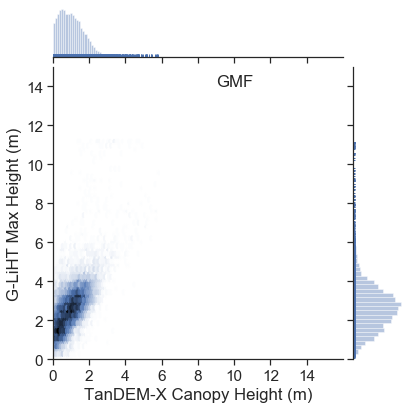

In [24]:
hexjointplot(groupedTDX_gliht_gmf, 'GMF')

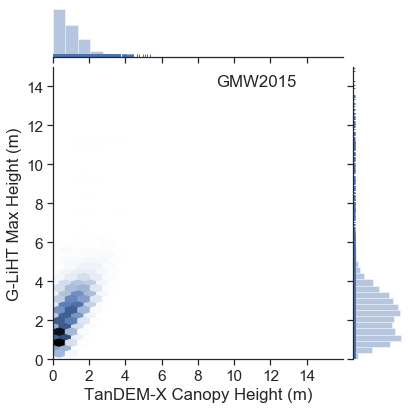

In [25]:
hexjointplot(groupedTDX_gliht_gmw2015, 'GMW2015')

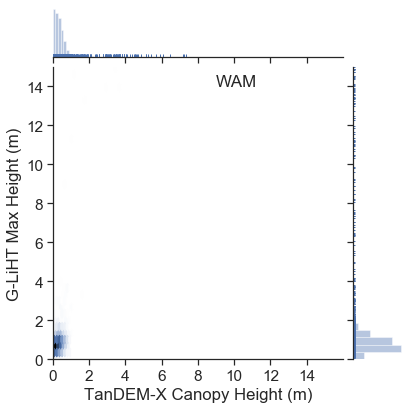

In [26]:
hexjointplot(groupedTDX_gliht_wam, 'WAM')

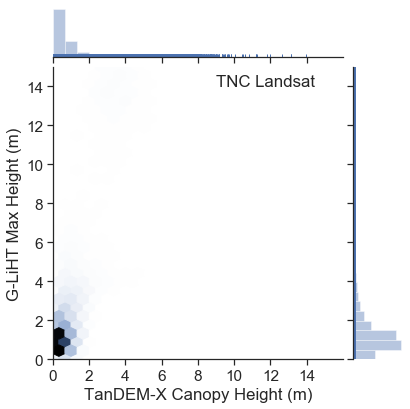

In [27]:
hexjointplot(groupedTDX_gliht_tnclandsat, 'TNC Landsat')

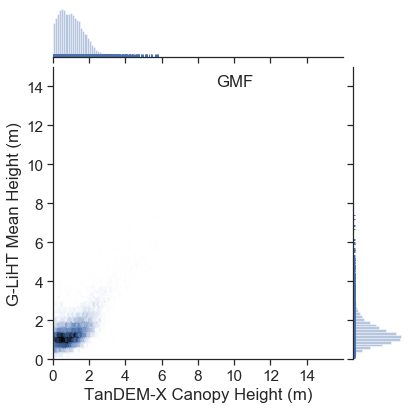

In [28]:
hexjointplot(groupedTDX_gliht_gmf, 'GMF', yatt='mean_z', ylabl="G-LiHT Mean Height (m)")

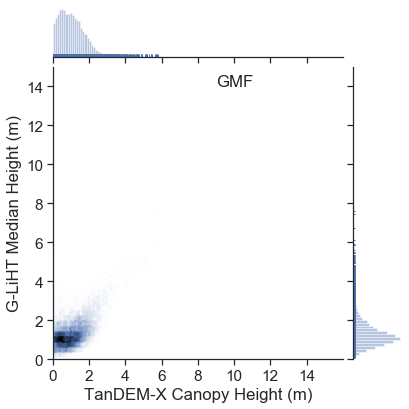

In [29]:
hexjointplot(groupedTDX_gliht_gmf, 'GMF', yatt='median_z', ylabl="G-LiHT Median Height (m)")

In [30]:
def linear_regress(df, x_att, y_att, fi=True):
    linear_regressor = LinearRegression(fit_intercept=fi)  # create object for the class
    X = df[x_att].values.reshape(-1, 1)
    Y = df[y_att].values.reshape(-1, 1)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='orange')
    plt.xlabel(x_att)
    plt.ylabel(y_att)
    plt.show()

    r_sq = linear_regressor.score(X, Y)
    print("R squared:", r_sq)
    intercept = linear_regressor.intercept_
    print("intercept:", intercept)
    slope = linear_regressor.coef_
    print("slope:", slope)
    rmse = np.sqrt(mean_squared_error(y_true=Y, y_pred=Y_pred))
    print("RMSE:", rmse)

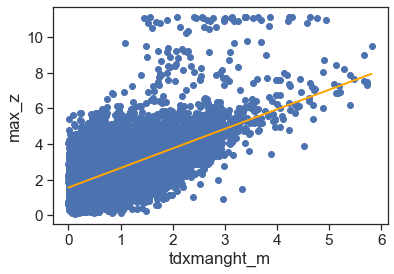

R squared: 0.3933926080273516
intercept: [1.54927182]
slope: [[1.0992429]]
RMSE: 0.9868993722162839


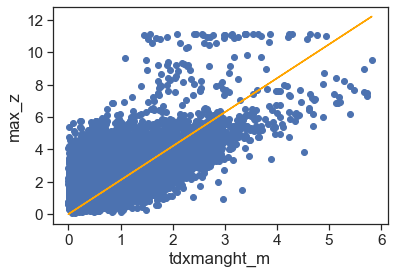

R squared: -0.08169481773800458
intercept: 0.0
slope: [[2.09699495]]
RMSE: 1.317866438461529


In [31]:
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'max_z', True)
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'max_z', False) # define intercept as 0

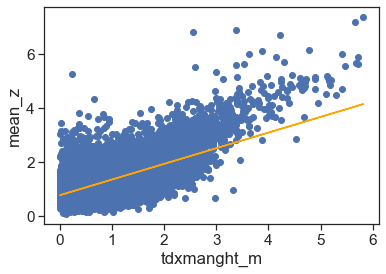

R squared: 0.38537352815842874
intercept: [0.75973413]
slope: [[0.58146152]]
RMSE: 0.5309139278436482


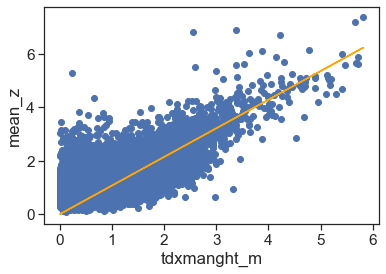

R squared: -0.01461049372126988
intercept: 0.0
slope: [[1.0707406]]
RMSE: 0.682131590604139


In [32]:
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'mean_z', True)
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'mean_z', False) # define intercept as 0

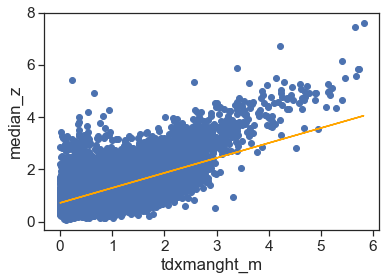

R squared: 0.3619107956851946
intercept: [0.71754436]
slope: [[0.57283741]]
RMSE: 0.5499329629848676


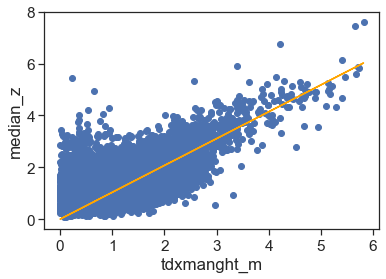

R squared: 0.016675055039337083
intercept: 0.0
slope: [[1.03494571]]
RMSE: 0.6826806319452569


In [33]:
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'median_z', True)
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'median_z', False) # define intercept as 0

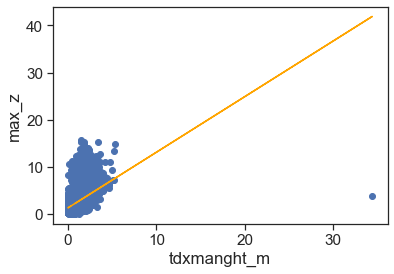

R squared: 0.334573367627478
intercept: [1.32754741]
slope: [[1.17894585]]
RMSE: 1.2110311666721152


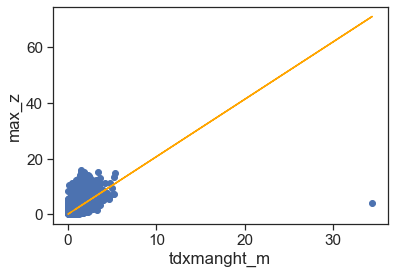

R squared: 0.026980730178133627
intercept: 0.0
slope: [[2.06567464]]
RMSE: 1.4644210111557165


In [34]:
linear_regress(groupedTDX_gliht_gmw2015, 'tdxmanght_m', 'max_z', True)
linear_regress(groupedTDX_gliht_gmw2015, 'tdxmanght_m', 'max_z', False) # define intercept as 0

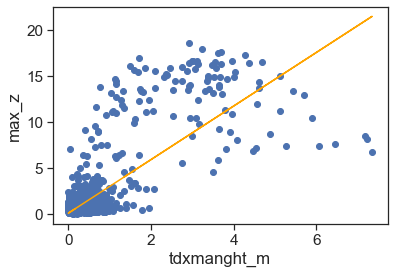

R squared: 0.5819229351781451
intercept: [0.09883012]
slope: [[2.91367815]]
RMSE: 1.6019822135683475


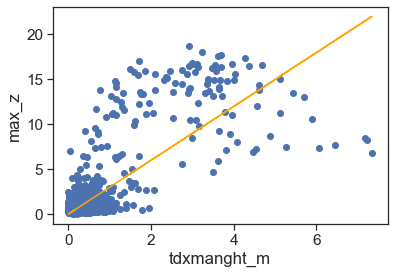

R squared: 0.5808303414786102
intercept: 0.0
slope: [[2.98435042]]
RMSE: 1.6040741408144275


In [35]:
linear_regress(groupedTDX_gliht_wam, 'tdxmanght_m', 'max_z', True)
linear_regress(groupedTDX_gliht_wam, 'tdxmanght_m', 'max_z', False) # define intercept as 0

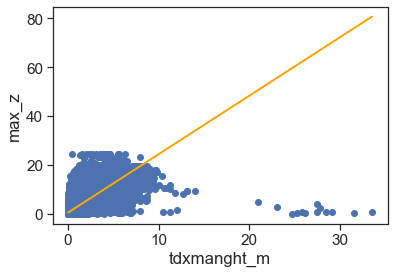

R squared: 0.6080928196132468
intercept: [0.59433121]
slope: [[2.39294397]]
RMSE: 2.634268036402924


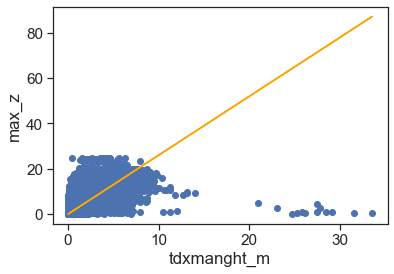

R squared: 0.5952342019975593
intercept: 0.0
slope: [[2.60039629]]
RMSE: 2.677134902671703


In [36]:
linear_regress(groupedTDX_gliht_tnclandsat, 'tdxmanght_m', 'max_z', True)
linear_regress(groupedTDX_gliht_tnclandsat, 'tdxmanght_m', 'max_z', False) # define intercept as 0

In [38]:
pts_gt0_gmf.describe()

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,dtm_z_m,tdx_id,tdxmanght_m
count,9.624330e+05,962433.000000,9.624330e+05,962433.000000,9.624330e+05,894779.000000,9.624330e+05,9.624330e+05,962433.0,212.0,779433.0,439845.0,962433.000000,9.624330e+05,962433.000000
mean,1.589839e+00,797142.040025,2.700180e+06,4.977897,4.182572e+07,8.494296,4.145150e+07,5.389489e+07,1.0,1.0,1.0,1.0,1.892048,2.613764e+08,1.373732
std,9.983523e-01,3394.365641,3.999021e+03,1.997511,9.335625e+05,3.012967,1.237980e+06,3.278255e+06,0.0,0.0,0.0,0.0,0.320016,5.834435e+06,0.727133
min,3.552714e-15,793067.500000,2.694142e+06,-5.000000,3.822647e+07,0.848500,3.667764e+07,4.095620e+07,1.0,1.0,1.0,1.0,0.887178,2.388642e+08,0.000176
25%,8.900000e-01,793600.500000,2.697794e+06,4.000000,4.148124e+07,6.788000,4.099094e+07,5.263962e+07,1.0,1.0,1.0,1.0,1.659328,2.592231e+08,0.878096
50%,1.390000e+00,797752.500000,2.699140e+06,5.000000,4.204985e+07,8.485000,4.174677e+07,5.490152e+07,1.0,1.0,1.0,1.0,1.898833,2.627866e+08,1.313034
75%,2.100000e+00,799608.500000,2.701712e+06,6.000000,4.238848e+07,10.182000,4.219342e+07,5.595802e+07,1.0,1.0,1.0,1.0,2.098852,2.649112e+08,1.779540
max,1.115000e+01,806771.500000,2.715710e+06,12.000000,4.327439e+07,13.576000,4.337459e+07,5.766780e+07,1.0,1.0,1.0,1.0,3.202220,2.704020e+08,5.818864


In [41]:
pts_gt0_gmf['tdxmanght_m'].describe()

count    962433.000000
mean          1.373732
std           0.727133
min           0.000176
25%           0.878096
50%           1.313034
75%           1.779540
max           5.818864
Name: tdxmanght_m, dtype: float64

In [42]:
pts_gt0_gmw2015['tdxmanght_m'].describe()

count    980606.000000
mean          1.302544
std           0.711922
min           0.000168
25%           0.803386
50%           1.258144
75%           1.731073
max          34.415531
Name: tdxmanght_m, dtype: float64

In [43]:
pts_gt0_wam['tdxmanght_m'].describe()

count    40731.000000
mean         0.877570
std          1.185460
min          0.000227
25%          0.247620
50%          0.447962
75%          0.758028
max          7.345562
Name: tdxmanght_m, dtype: float64

In [46]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pts_gt0_tnclandsat['tdxmanght_m'].describe()

count   3326342.00000
mean          2.13027
std           1.76092
min           0.00002
25%           0.74869
50%           1.48312
75%           3.34459
max          33.52917
Name: tdxmanght_m, dtype: float64

In [47]:
pd.reset_option('display.float_format')